# Classifier free guidance

## Score based diffusion model

We can derive the diffusion model by appealing Tweedie’s Formula, which states that for a random variable $\mathbf{z}\sim \mathcal{N}(\mathbf{z};\mu_z, \Sigma_z)$, we have 

$$\mathbb{E}[\mu_z|\mathbf{z}] = \mathbf{z} + \Sigma_z \nabla_{\mathbf{z}}\log p(\mathbf{z})$$

Since $q(\mathbf{x}_t|\mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t}\mathbf{x}_0, (1-\bar{\alpha}_t)\mathbf{I})$, applying Tweedie’s Formula gives us

$$\mathbb{E}[\mu_{\mathbf{x}_t}|\mathbf{x}_t] = \mathbf{x}_t+ (1-\bar{\alpha}_t) \nabla_{\mathbf{x}_t}\log p(\mathbf{x}_t)$$

Therefore, we have

$$\sqrt{\bar{\alpha}_t}\mathbf{x}_0=\mathbf{x}_t+ (1-\bar{\alpha}_t) \nabla_{\mathbf{x}_t}\log p(\mathbf{x}_t)\implies \mathbf{x}_0=\frac{1}{\sqrt{\bar{\alpha}_t}}(\mathbf{x}_t+ (1-\bar{\alpha}_t) \nabla_{\mathbf{x}_t}\log p(\mathbf{x}_t))$$

If we substitute this into the formula of $\mu_q$, we have

$$
\begin{align*}
\mu_q(\mathbf{x}_t, t) &= \frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})\mathbf{x}_t+\sqrt{\bar{\alpha}_{t-1}}(1-\alpha_t)\mathbf{x}_0}{1-\bar{\alpha}_t}\\
&= \frac{1}{\sqrt{\alpha_t}}\mathbf{x}_t+\frac{1-\alpha_t}{\sqrt{\alpha_t}}\nabla_{\mathbf{x}_t}\log p(\mathbf{x}_t))
\end{align*}$$

Now, for the parameterized distribution, instead of learning the noise, we can instead learn an estimate to the score function 

$$\mu_\theta(\mathbf{x}_t, t) =\frac{1}{\sqrt{\alpha_t}}\mathbf{x}_t+\frac{1-\alpha_t}{\sqrt{\alpha_t}}s_{\theta}(\mathbf{x}_t, t)$$

And, after simplifying the objective becomes.

## Classifier guidance

Similar to VAE and GAN, for diffusion model we can also introduce control over the class generated. If we condition on the label $y$, then the score becomes 

$$\nabla_{\mathbf{x}_t}\log p(\mathbf{x}_t) \rightarrow \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t|y)$$

By using Bayes rule, we can rewrite the conditional score as 

$$p(\mathbf{x}_t|y) = \nabla \log p(\mathbf{x}_t) + \log p(y|\mathbf{x}_t) - \log p(y)$$

The first term is the gradient guidance of the unconditional diffusion model. To include classifier guidance, we simply add an extra gradient from $p(y|\mathbf{x}_t)$. This can be done through trainiing a classifier and use the gradient of the classifer for guidance. This method is known as classifer guidance. To control the strength of guidance, in practice, we include a hyperparameter $\lambda$

$$p(\mathbf{x}_t|y) = \nabla \log p(\mathbf{x}_t) + \lambda\log p(y|\mathbf{x}_t)$$

## Classifier free guidance

One problem about classifer guidance is that we need to train another neural network to perform classification task, this increase the computational burden of training. In 2020, Jonathan Ho proposed classifier free guidance, which essentially removes the need of a classifier for guidance. Note that

$$\nabla \log p(y|\mathbf{x}_t)=\nabla\log p(\mathbf{x}_t|y) - \nabla \log p(\mathbf{x}_t)$$

If we plug this into classifer guidance with scale $\lambda$, we get

$$
\begin{align*}
    \nabla \log p(\mathbf{x}_t) + \lambda\log p(y|\mathbf{x}_t) &= \nabla \log p(\mathbf{x}_t) + \lambda[\nabla\log p(\mathbf{x}_t|y) - \nabla \log p(\mathbf{x}_t)]\\
    &= \lambda \nabla\log p(\mathbf{x}_t|y)- (\lambda-1)\nabla \log p(\mathbf{x}_t)\\
\end{align*}
$$

If we estimate $\nabla\log p(\mathbf{x}_t|y)$ by a conditional score $s_\theta(\mathbf{x}_t, y, t)$ and $\nabla \log p(\mathbf{x}_t)$ by a unconditional score $s_\theta(\mathbf{x}_t, \emptyset, t)$, then the above line can be written as

$$
\begin{align*}
    \nabla \log p(\mathbf{x}_t) + \lambda\log p(y|\mathbf{x}_t)
    &= \lambda \nabla\log p(\mathbf{x}_t|y)- (\lambda-1)\nabla \log p(\mathbf{x}_t)\\
    &= s_\theta(\mathbf{x}_t, \emptyset, t) +\lambda (s_\theta(\mathbf{x}_t, y, t)-s_\theta(\mathbf{x}_t, \emptyset, t))
\end{align*}
$$

This removes the need of using a classifier! Instead, we only need to train a conditional and uncondition score estimator. 

## Classifier free guidance implementation

We now implement the classifier free guidance method. We follow the exact same U-Net architecture as before. We only need to make a small modification on the forward method: the model now also takes in a label. The label could be a number or None, which represents the unconditional score. If the label is a number, we embed the label and add it to the positional encoding. 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mnist_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=32, shuffle=True)

cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)
cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=32, shuffle=True)

In [10]:
def forward(self, x, t, label):
    t = timestep_embedding(t, self.embed_dim)
    if label is not None:
        t += self.class_embed(label)
            
    ## Prepare for downsample path
    x0 = self.in_conv(x)

    # Start downsampling
    x1 = self.down_attn1(self.down1(x0, t))
    x2 = self.down_attn2(self.down2(x1, t))
    x3 = self.down_attn3(self.down3(x2, t))

    ## Bottleneck
    x3 = self.bottleneck1(x3)
    x3 = self.bottleneck2(x3)
    x3 = self.bottleneck3(x3)
        
    ## Upsample
    x2 = self.up_attn3(self.up3(x3, x2, t))
    x1 = self.up_attn2(self.up2(x2, x1, t))
    x0 = self.up_attn1(self.up1(x1, x0, t))
    x0 = self.out_conv(x0)
    return x0

We also need to modify the sample method in the Diffusion class. During sampling, we need to interpolate between conditional and unconditional score, based on the scale parameter. This is done using the lerp method in torch.

In [11]:
def sample(self, n_samples, labels, scale=3):
    self.unet.eval()
    with torch.no_grad():
        x = torch.randn(n_samples, self.in_channels, self.img_size, self.img_size).to(self.device)
        for t in reversed(range(1, self.timesteps)):
            time = (t * torch.ones(n_samples, device=self.device)).long()
            cond_pred_noise = self.unet(x, time, labels)
            uncond_pred_noise = self.unet(x, time, None)
            pred_noise = torch.lerp(uncond_pred_noise, cond_pred_noise, scale)
            alpha, alpha_, beta = self.alpha[time], self.alpha_[time], self.beta[time]
            alpha = alpha[:, None, None, None]
            alpha_ = alpha_[:, None, None, None]
            beta = beta[:, None, None, None]
            noise = torch.randn(x.shape) if t > 1 else torch.zeros_like(x)
            noise = noise.to(self.device)
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_))) * pred_noise) + torch.sqrt(beta) * noise
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x

## MNIST

In [ ]:
model = Diffusion(in_channels=1, embed_dim=256, n_heads=4, img_size=32, timesteps=1000, beta_min=1e-4, beta_max=0.02, device=DEVICE).to(DEVICE)
optimizer = optim.Adam(model.unet.parameters(), lr=5e-5)
train(model, trainloader, optimizer, 30, device=DEVICE)

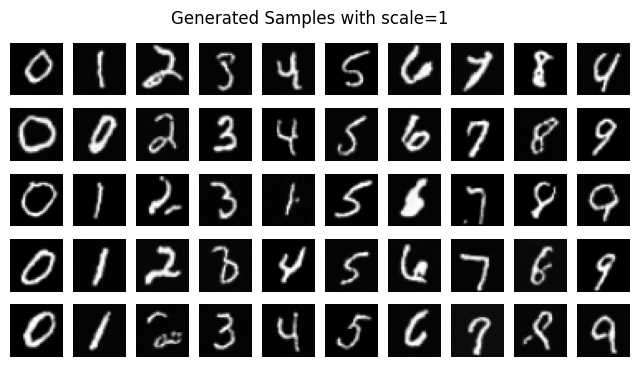

In [16]:
fig, ax = plt.subplots(5, 10, figsize=(8, 4))
fig.suptitle('Generated Samples with scale=1', fontsize=12)
for i in range(5):
    samples = model.sample(10, torch.tensor(np.arange(10), device=DEVICE), scale=1)
    samples = samples.permute(0, 2, 3, 1).detach().cpu().numpy()
    for j in range(10):
        ax[i, j].imshow(samples[j], cmap="gray")
        ax[i, j].axis("off")
plt.subplots_adjust(top=0.9)

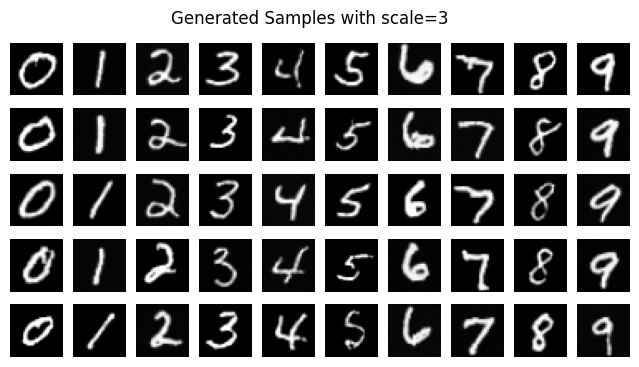

In [17]:
fig, ax = plt.subplots(5, 10, figsize=(8, 4))
fig.suptitle('Generated Samples with scale=3', fontsize=12)
for i in range(5):
    samples = model.sample(10, torch.tensor(np.arange(10), device=DEVICE), scale=3)
    samples = samples.permute(0, 2, 3, 1).detach().cpu().numpy()
    for j in range(10):
        ax[i, j].imshow(samples[j], cmap="gray")
        ax[i, j].axis("off")
plt.subplots_adjust(top=0.9)

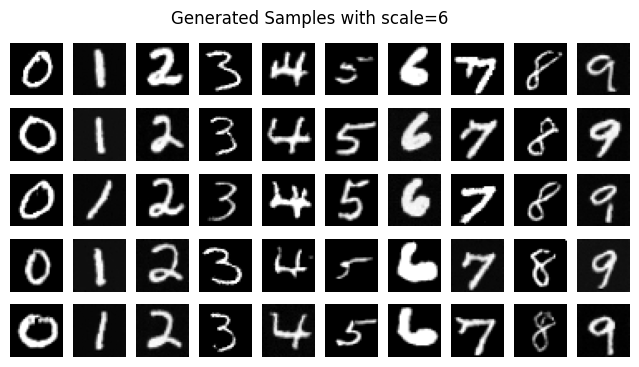

In [18]:
fig, ax = plt.subplots(5, 10, figsize=(8, 4))
fig.suptitle('Generated Samples with scale=6', fontsize=12)
for i in range(5):
    samples = model.sample(10, torch.tensor(np.arange(10), device=DEVICE), scale=6)
    samples = samples.permute(0, 2, 3, 1).detach().cpu().numpy()
    for j in range(10):
        ax[i, j].imshow(samples[j], cmap="gray")
        ax[i, j].axis("off")
plt.subplots_adjust(top=0.9)

## CIFAR10

In [ ]:
model = Diffusion(in_channels=3, embed_dim=256, n_heads=4, img_size=32, timesteps=1000, beta_min=1e-4, beta_max=0.02, device=DEVICE).to(DEVICE)
optimizer = optim.Adam(model.unet.parameters(), lr=5e-5)
train(model, trainloader, optimizer, 30, device=DEVICE)

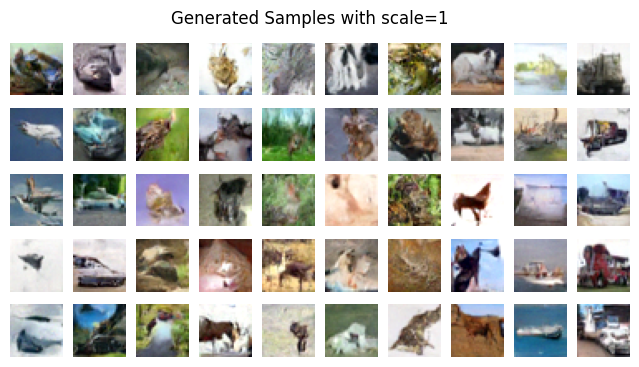

In [47]:
fig, ax = plt.subplots(5, 10, figsize=(8, 4))
fig.suptitle('Generated Samples with scale=1', fontsize=12)
for i in range(5):
    samples = model.sample(10, torch.tensor(np.arange(10), device=DEVICE), scale=1)
    samples = samples.permute(0, 2, 3, 1).detach().cpu().numpy()
    for j in range(10):
        ax[i, j].imshow(samples[j], cmap="gray")
        ax[i, j].axis("off")
plt.subplots_adjust(top=0.9)

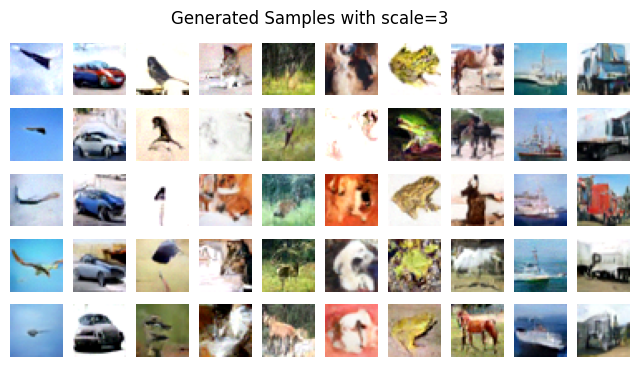

In [48]:
fig, ax = plt.subplots(5, 10, figsize=(8, 4))
fig.suptitle('Generated Samples with scale=3', fontsize=12)
for i in range(5):
    samples = model.sample(10, torch.tensor(np.arange(10), device=DEVICE), scale=3)
    samples = samples.permute(0, 2, 3, 1).detach().cpu().numpy()
    for j in range(10):
        ax[i, j].imshow(samples[j], cmap="gray")
        ax[i, j].axis("off")
plt.subplots_adjust(top=0.9)

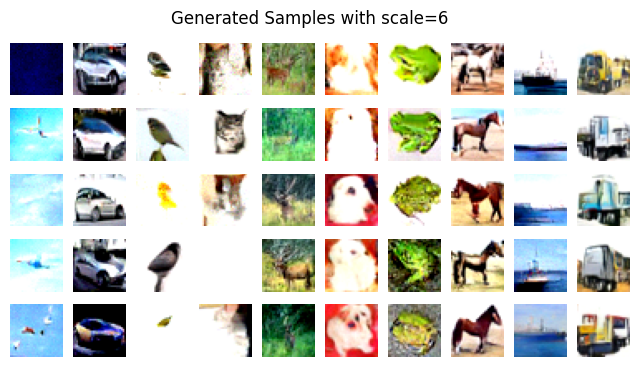

In [49]:
fig, ax = plt.subplots(5, 10, figsize=(8, 4))
fig.suptitle('Generated Samples with scale=6', fontsize=12)
for i in range(5):
    samples = model.sample(10, torch.tensor(np.arange(10), device=DEVICE), scale=6)
    samples = samples.permute(0, 2, 3, 1).detach().cpu().numpy()
    for j in range(10):
        ax[i, j].imshow(samples[j], cmap="gray")
        ax[i, j].axis("off")
plt.subplots_adjust(top=0.9)